In [1]:
import os
from collections import Counter
import pandas as pd
import numpy as np

from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, roc_auc_score, auc, precision_recall_curve, roc_curve

from xgboost import XGBClassifier
import spacy

import time
from tqdm import tqdm
from prettytable import PrettyTable

from sentence_transformers import SentenceTransformer

import tensorflow_hub as hub
import tensorflow as tf

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix



%matplotlib inline

2023-03-18 10:04:52.441762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-18 10:04:52.989019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-18 10:04:52.989060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-18 10:04:52.989063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
df = pd.read_csv('res_all_v2_20.csv')
df.reset_index(inplace=True, drop=True)

df.sample(15)

Model  Precision  Recall  Jaccard_score  f1_score  Accuracy  \
51  SGDClassifier       0.90    0.24           0.24      0.38      0.22   
4   XGBClassifier       0.84    0.65           0.58      0.73      0.53   
41  SGDClassifier       0.86    0.61           0.55      0.71      0.51   
6       LinearSVC       0.87    0.46           0.43      0.60      0.42   
12  SGDClassifier       0.68    0.61           0.48      0.65      0.41   
45  SGDClassifier       0.82    0.57           0.51      0.67      0.46   
26      LinearSVC       0.86    0.49           0.45      0.62      0.43   
11      LinearSVC       0.87    0.54           0.50      0.66      0.47   
16      LinearSVC       0.85    0.64           0.57      0.73      0.54   
27  SGDClassifier       0.65    0.63           0.47      0.64      0.40   
62  XGBClassifier       0.83    0.70           0.61      0.76      0.58   
9   XGBClassifier       0.84    0.65           0.58      0.73      0.53   
31      LinearSVC       0.86    0.56           0.51      0.68      0.48   
71  SGDClassifier       0.87    0.71           0.64      0.78      0.60   
60  SGDClassifier       0.83    0.70           0.61      0.76      0.58   

                                     Experiment_title  
51  Truncated SVD (1000 dim) : title + body (seuil...  
4         Sac de mots simple, CountVectorizer : title  
41  Sac de mots ngram_range=(1, 2), TfidfVectorize...  
6   Sac de mots simple, CountVectorizer : title (s...  
12  Sac de mots ngram_range=(1, 2), CountVectorize...  
45  Truncated SVD (500 dim) : title + body (seuil ...  
26  Sac de mots simple, CountVectorizer : title + ...  
11  Sac de mots ngram_range=(1, 2), CountVectorize...  
16  Sac de mots simple, TfidfVectorizer : title (s...  
27  Sac de mots simple, CountVectorizer : title + ...  
62         use : title + body not clean (seuil : 0.5)  
9   Sac de mots simple, CountVectorizer : title (s...  
31  Sac de mots ngram_range=(1, 2), CountVectorize...  
71     all-mpnet-base-v2 : DL not clean (seuil : 0.5)  
60         use : title + body not clean (seuil : 0.5)

<AxesSubplot: xlabel='count', ylabel='Model'>

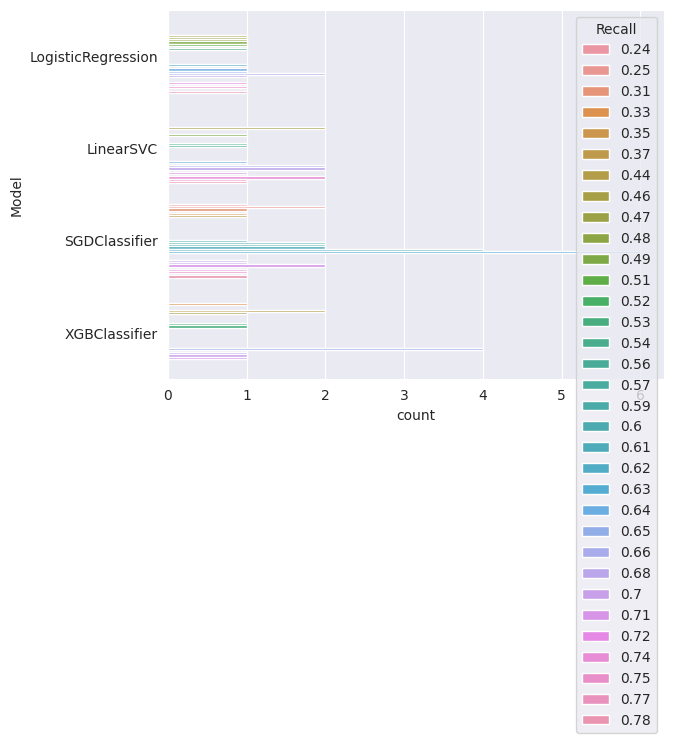

In [5]:
sns.countplot(data=df, y="Model", hue="Recall")

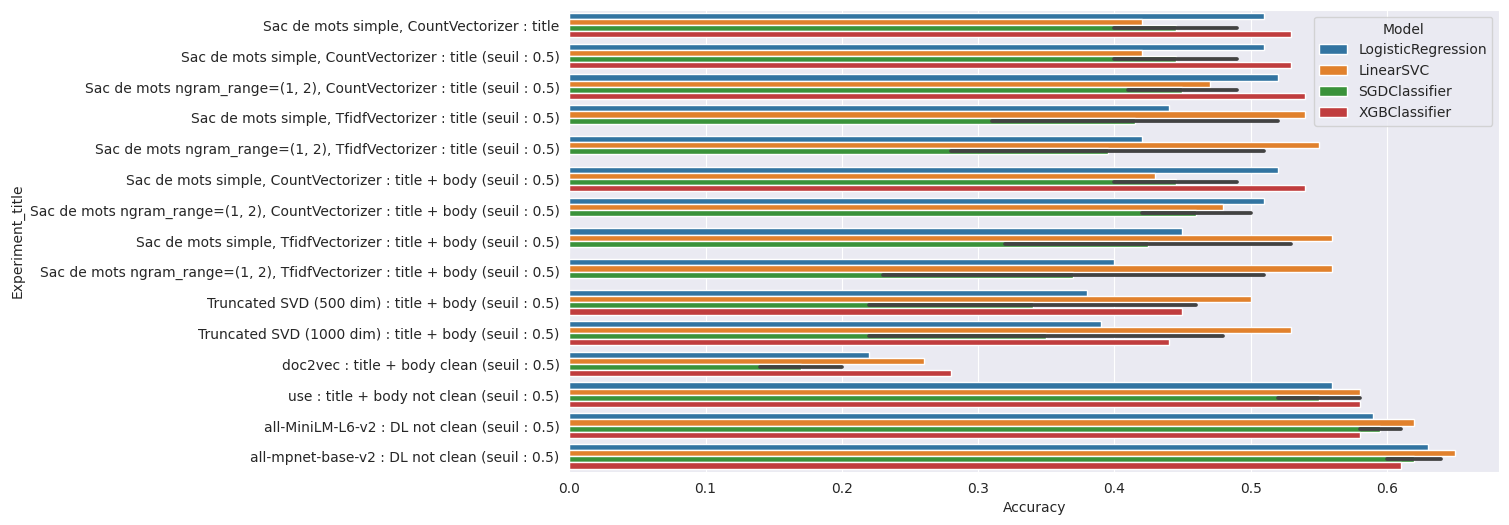

In [14]:
f, ax = plt.subplots(figsize=(12,6))
sns.barplot(data=df, x="Accuracy", y="Experiment_title", hue="Model")
plt.show()

In [7]:
t = df.groupby(by="Experiment_title")

In [9]:
for s in t:
    print(s)

('Sac de mots ngram_range=(1, 2), CountVectorizer : title (seuil : 0.5)',                  Model  Precision  Recall  Jaccard_score  f1_score  Accuracy  \
10  LogisticRegression       0.81    0.64           0.56      0.72      0.52   
11           LinearSVC       0.87    0.54           0.50      0.66      0.47   
12       SGDClassifier       0.68    0.61           0.48      0.65      0.41   
13       SGDClassifier       0.80    0.62           0.54      0.70      0.49   
14       XGBClassifier       0.85    0.65           0.58      0.74      0.54   

                                     Experiment_title  
10  Sac de mots ngram_range=(1, 2), CountVectorize...  
11  Sac de mots ngram_range=(1, 2), CountVectorize...  
12  Sac de mots ngram_range=(1, 2), CountVectorize...  
13  Sac de mots ngram_range=(1, 2), CountVectorize...  
14  Sac de mots ngram_range=(1, 2), CountVectorize...  )
('Sac de mots ngram_range=(1, 2), CountVectorizer : title + body (seuil : 0.5)',                  Model  Pre

In [21]:
# model = SentenceTransformer('microsoft/codebert-base')
# model = SentenceTransformer('jeniya/BERTOverflow')

IndexError: Column(s) Experiment_title already selected